---
**License**

 VacuumStudyAdiabatic

 Mon Jun 01 09:20:00 2020
 Copyright  2020
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 VacuumStudyAdiabatic
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np

from IPython.display import HTML

from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
%matplotlib inline

# Figure utilities

In [2]:
fig_width_pt  = 246.0 * 2.0                 # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27                 # Convert pt to inch
golden_mean   = (math.sqrt (5) - 1.0) / 2.0 # Aesthetic ratio
fig_width     = fig_width_pt*inches_per_pt  # width in inches
fig_height    = fig_width*golden_mean       # height in inches
fig_size      = [ fig_width, fig_height ]

params = {
          'axes.labelsize' : 10,
          'font.size'      : 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex'    : True,
          'figure.figsize' : fig_size,
          'animation.embed_limit' : 2**128
         }

mpl.rcParams.update (params)

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base == 1.0:
          if exponent == 0.0:
            return r"1"
          else:
            return r"10^{{{1}}}".format (int(exponent))
        elif exponent == 0.0:
          return r"{0}".format (base)
        else:
          return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

# Initializing the library

In [3]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# Complex structure quantization object

Below we define our object as a child of the complex structure quantization object Ncm.CSQ1D

In [4]:
csq1d = Nc.DECont (Omegaw = 1.0, OmegaL = 0.0, w = 1.0e-6, cs2 = 1.0e-6)

ti = 1.0e-10
tf = 5.0e-3

ki    = 1.0e0
kf    = 1.0e2
k_a   = np.geomspace (ki, kf, 1000)

csq1d.set_k (kf)

Found, tAD = csq1d.find_adiab_time_limit (None, ti, tf, 1.0e-5)

alpha0, dgamma0, _, _ = csq1d.eval_adiab_at (None, tAD)
xi0 = csq1d.eval_xi (None, tAD, csq1d.get_k ())
gamma0 = xi0 + dgamma0

Found, tfAD = csq1d.find_adiab_time_limit (None, ti, 1.0e1, 1.0e-1)
if Found:
    tf = tfAD

print (ti, tAD, tf)

mylw = 1.0

r_a = np.linspace (0.0, 0.05, 5)
theta_a = np.linspace (0.0, 2.0 * math.pi, 2, endpoint = False)

colors = cm.copper(np.linspace(0, 1, len(r_a)))

1e-10 5.059812577716686e-05 0.005059717874032467


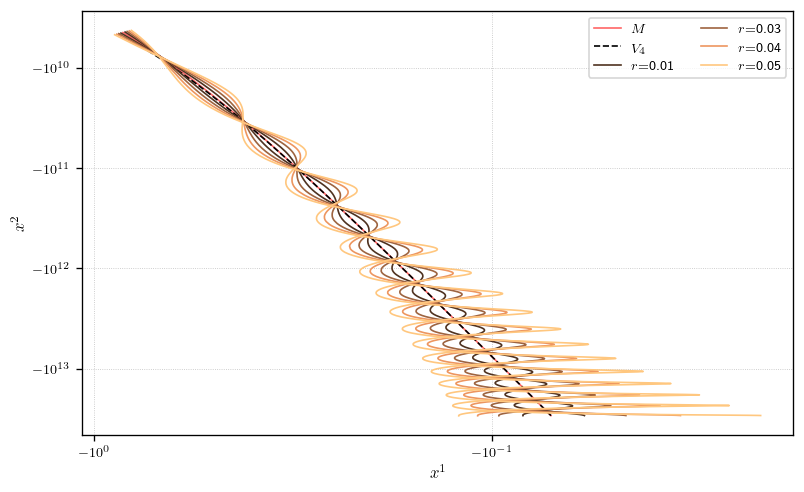

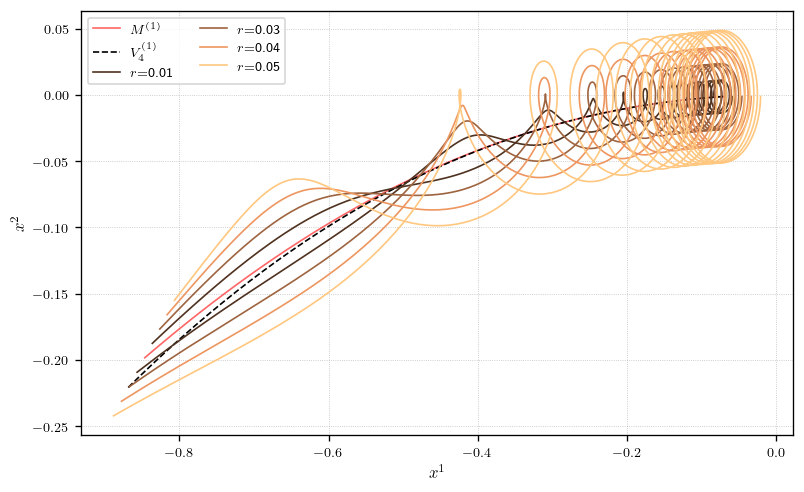

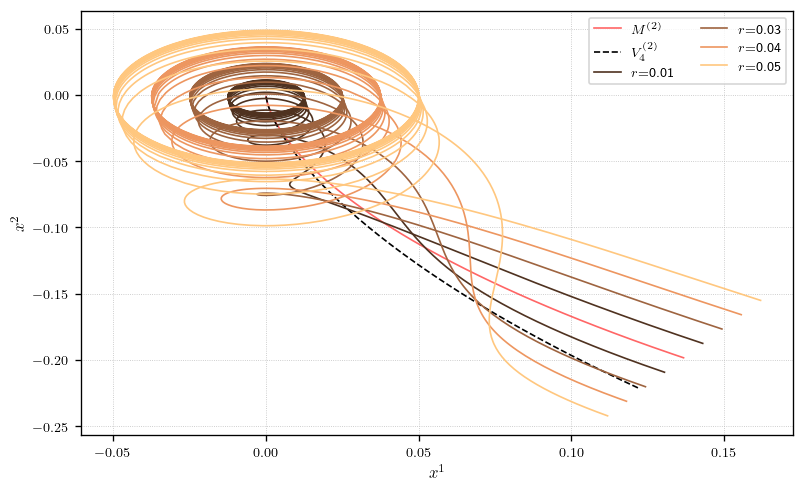

In [5]:

fig = plt.figure (dpi = 120)

for r, c in zip (r_a, colors):
    for theta in theta_a:
        
        if r == 0 and theta > 0.0:
            continue
        
        alpha, dgamma = csq1d.alpha_gamma_circle (None, alpha0, dgamma0, r, theta)
                
        csq1d.set_init_cond (Ncm.CSQ1DEvolState.ADIABATIC, tAD, alpha, dgamma)
        csq1d.set_tf (tf)
        csq1d.prepare ()
        
        t_a, tmax = csq1d.get_time_array ()
        mx1x2 = np.array ([csq1d.get_minkowski_frame (None, 0, t) for t in t_a])

        if r == 0.0:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color='r', alpha=0.6, label = r'$M$')
            
            Valphadgamma = zip (t_a, np.array ([csq1d.eval_adiab_at (None, t) for t in t_a]))
            Vx1x2 = np.array ([csq1d.alpha_dgamma_to_minkowski_frame (None, 0, t, alpha, dgamma) 
                               for t, (alpha, dgamma, _, _) in Valphadgamma])
            
            plt.plot (Vx1x2[:,0], Vx1x2[:,1], 'k--', lw=mylw, alpha=1.0, label = r'$V_4$')
            
        elif theta == 0.0:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color=c, label = r'$r$=%.2f' % (r))
        else:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color=c)


plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)

plt.xscale('symlog', linthresh=1.0e-15)
plt.yscale('symlog', linthresh=1.0e-10)

plt.xlabel ("$x^1$")
plt.ylabel ("$x^2$")

fig.tight_layout ()
plt.savefig ("adiab_vacuum_f0.pdf")
plt.show ()

fig = plt.figure (dpi = 120)

for r, c in zip (r_a, colors):
    for theta in theta_a:
        
        if r == 0.0 and theta > 0.0:
            continue
        
        alpha, dgamma = csq1d.alpha_gamma_circle (None, alpha0, dgamma0, r, theta)
                
        csq1d.set_init_cond (Ncm.CSQ1DEvolState.ADIABATIC, tAD, alpha, dgamma)
        csq1d.set_tf (tf)
        csq1d.prepare ()
        
        t_a, tmax = csq1d.get_time_array ()
        mx1x2 = np.array ([csq1d.get_minkowski_frame (None, 1, t) for t in t_a])

        if r == 0.0:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color='r', alpha=0.6, label = r'$M^{(1)}$')

            Valphadgamma = zip (t_a, np.array ([csq1d.eval_adiab_at (None, t) for t in t_a]))
            Vx1x2 = np.array ([csq1d.alpha_dgamma_to_minkowski_frame (None, 1, t, alpha, dgamma) 
                               for t, (alpha, dgamma, _, _) in Valphadgamma])
            
            plt.plot (Vx1x2[:,0], Vx1x2[:,1], 'k--', lw=mylw, alpha=1.0, label = r'$V_4^{(1)}$')
        elif theta == 0.0:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color=c, label = r'$r$=%.2f' % (r))
        else:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color=c)


plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)

plt.xlabel ("$x^1$")
plt.ylabel ("$x^2$")

fig.tight_layout ()
plt.savefig ("adiab_vacuum_f1.pdf")
plt.show ()

fig = plt.figure (dpi = 120)

for r, c in zip (r_a, colors):
    for theta in theta_a:
        
        if r == 0 and theta > 0.0:
            continue
        
        alpha, dgamma = csq1d.alpha_gamma_circle (None, alpha0, dgamma0, r, theta)
                
        csq1d.set_init_cond (Ncm.CSQ1DEvolState.ADIABATIC, tAD, alpha, dgamma)
        csq1d.set_tf (tf)
        csq1d.prepare ()
        
        t_a, tmax = csq1d.get_time_array ()
        mx1x2 = np.array ([csq1d.get_minkowski_frame (None, 2, t) for t in t_a])

        if r == 0.0:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color='r', alpha=0.6, label = r'$M^{(2)}$')

            Valphadgamma = zip (t_a, np.array ([csq1d.eval_adiab_at (None, t) for t in t_a]))
            Vx1x2 = np.array ([csq1d.alpha_dgamma_to_minkowski_frame (None, 2, t, alpha, dgamma) 
                               for t, (alpha, dgamma, _, _) in Valphadgamma])
            
            plt.plot (Vx1x2[:,0], Vx1x2[:,1], 'k--', lw=mylw, alpha=1.0, label = r'$V^{(2)}_4$')

        elif theta == 0.0:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color=c, label = r'$r$=%.2f' % (r))
        else:
            plt.plot (mx1x2[:,0], mx1x2[:,1], lw=mylw, color=c)

plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)

plt.xlabel ("$x^1$")
plt.ylabel ("$x^2$")

fig.tight_layout ()
plt.savefig ("adiab_vacuum_f2.pdf")
plt.show ()



In [6]:
csq1d.set_reltol (1.0e-11)

def compute_J(k):
    csq1d.set_k (k)
    Found, tAD = csq1d.find_adiab_time_limit (None, ti, tf, 1.0e-6)
    csq1d.set_init_cond_adiab (None, tAD)
    csq1d.set_tf (1.0e10)
    csq1d.prepare ()

    t_a, t_s = csq1d.get_time_array ()

    J = csq1d.get_J_at (None, t_a[-1])
    
    return J

In [7]:
J_a = []
k_a = np.geomspace (1.0e0, 1.0e2, 1000)
for k in k_a:
    J_a.append (np.array(list(compute_J(k))))
    
J_a = np.array (J_a)

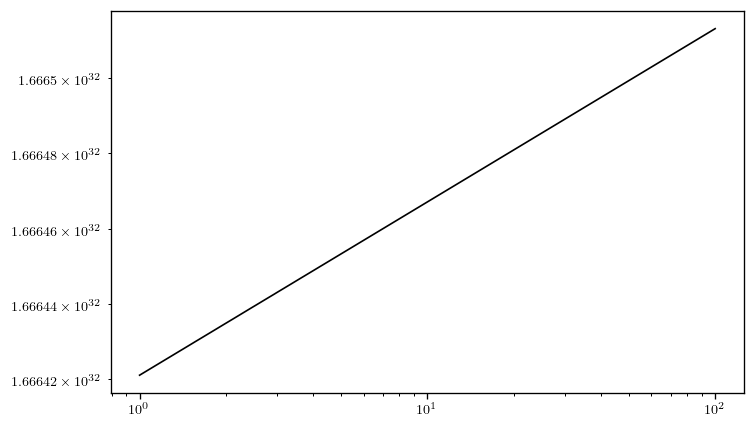

In [8]:
fig = plt.figure (dpi=120)

plt.plot (k_a, (k_a**3)*J_a[:,0], lw=mylw, c='k', label = r'$J_{00}$')

plt.xscale("log")
plt.yscale("log")


74.19340122193023 1.1999589270207533e-05


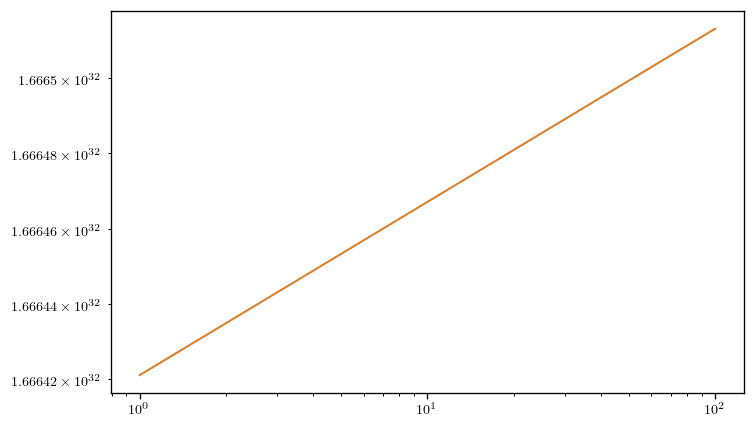

In [9]:
NPfit = 50
a, b = np.polyfit(np.log(k_a[:NPfit]),np.log((k_a[:NPfit]**3)*J_a[:NPfit,0]),1)
print (b, a)

fig = plt.figure (dpi=120)

plt.plot (k_a, (k_a**3)*J_a[:,0], lw=mylw, label = r'$J_{00}$')
plt.plot (k_a, np.exp(b + a*np.log(k_a)), lw=mylw, label = r'$J_{00}$')

plt.xscale("log")
plt.yscale("log")

